In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"]=300
from sklearn.metrics import roc_auc_score


In [3]:
data_dir="./results/MLP_split_large_ave_Adam_drop_complex"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"test_pred_result.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)
with open(preds_path,"rb") as f:
    pred_results=pickle.load(f)


In [4]:
score


{'accuracy': 0.6155857740585774,
 'precision': 0.596015260703688,
 'recall': 0.7311492459698388,
 'f1': 0.6567024754787483,
 'confusion_matrix': array([[ 948,  953],
        [ 517, 1406]]),
 'fpr_all': array([0.00000000e+00, 5.26038927e-04, 5.26038927e-04, ...,
        9.98947922e-01, 9.99473961e-01, 1.00000000e+00]),
 'tpr_all': array([0.00000000e+00, 0.00000000e+00, 5.20020801e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'roc_thresh': array([1.9496393 , 0.9496394 , 0.9361806 , ..., 0.02084319, 0.01970547,
        0.01004284], dtype=float32),
 'auc_roc': 0.6636321633822744}

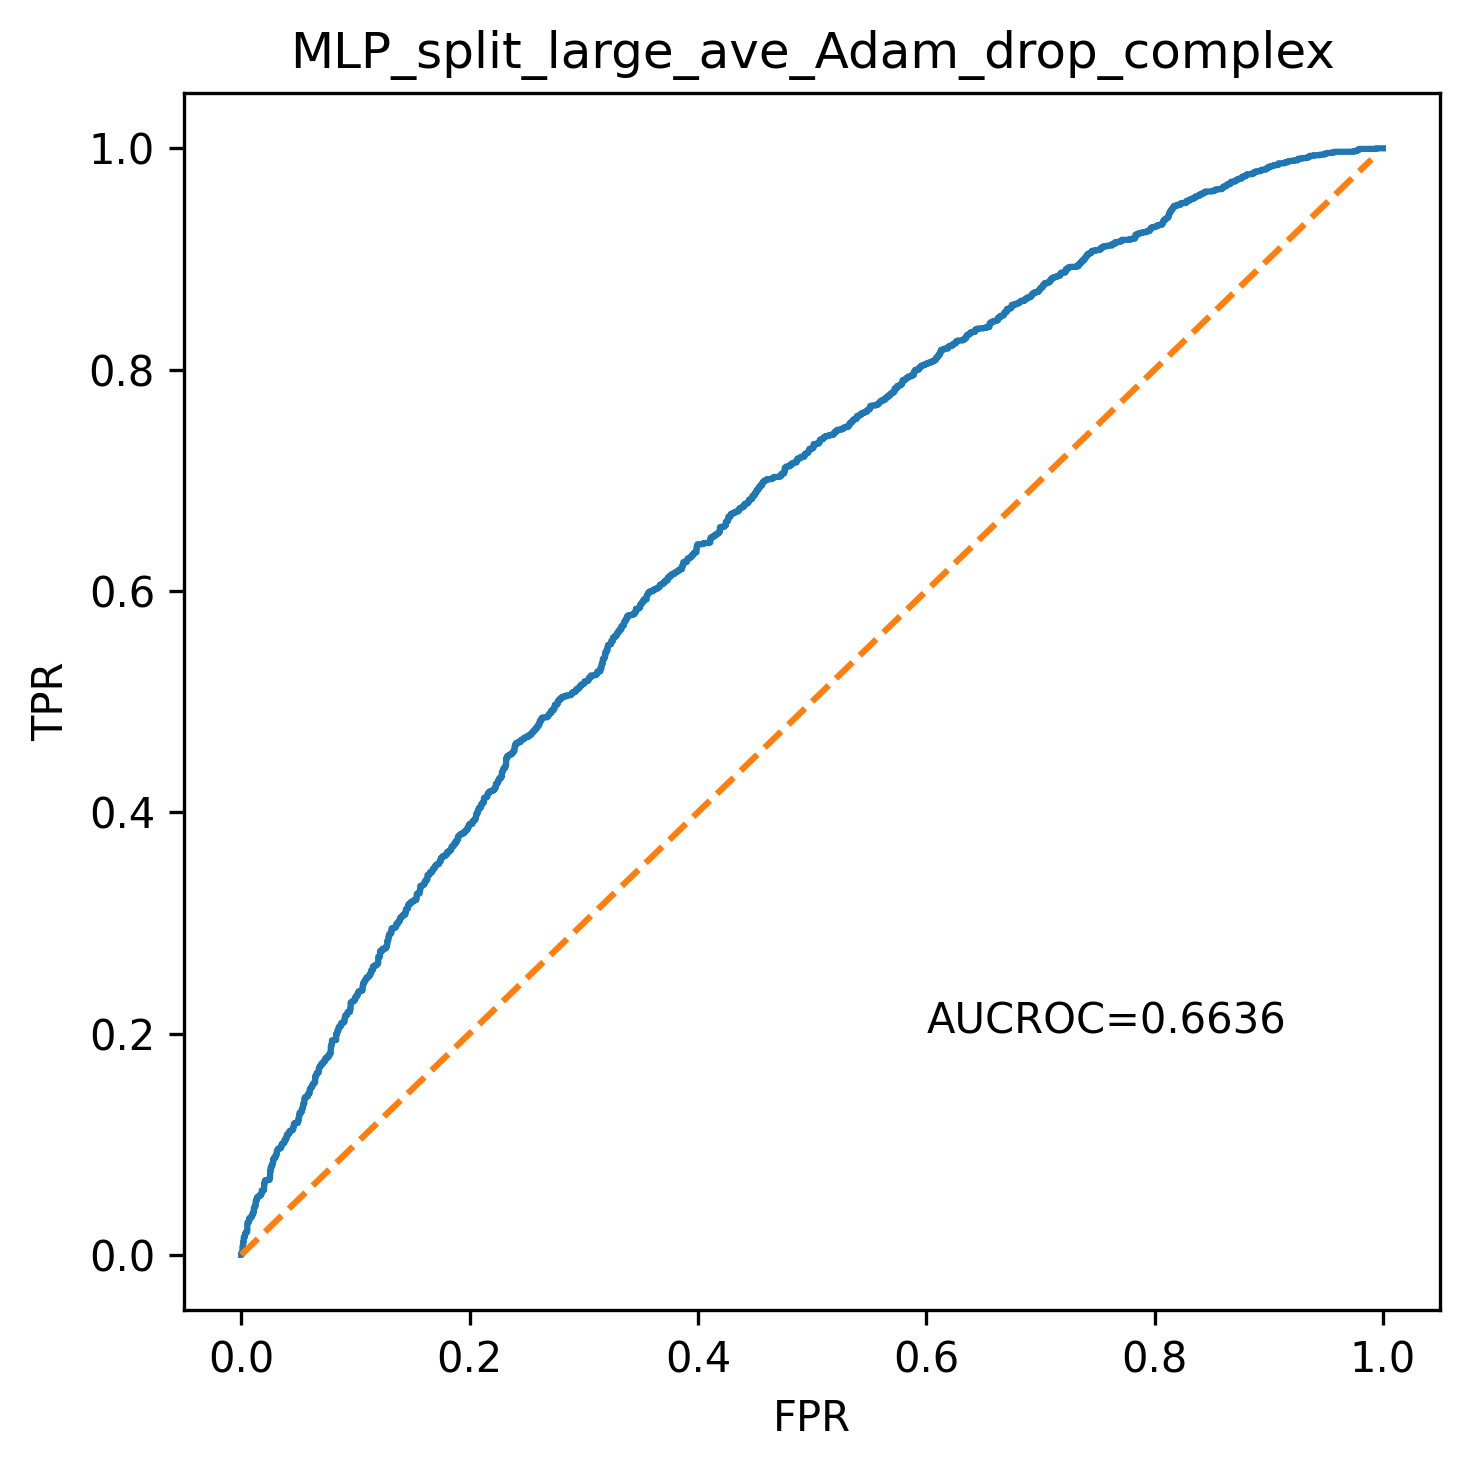

In [10]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
auc_roc=roc_auc_score(pred_results[1],pred_results[2])
plt.plot(score["fpr_all"],score["tpr_all"])
plt.plot(line,line,linestyle="--")
plt.text(0.6,0.2,f"AUCROC={auc_roc:.4f}")
plt.title(os.path.basename(data_dir))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.savefig(f"./results/imgs/aucroc_{os.path.basename(data_dir)}")